# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Fax/FINKI/Semestar-7/NLP/Project/

[Errno 2] No such file or directory: 'drive/MyDrive/Fax/FINKI/Semestar-7/NLP/Project/'
/content/drive/MyDrive/Fax/FINKI/Semestar-7/NLP/Project


In [ ]:
pip install transformers

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
import re
import seaborn as sns
import spacy
import xml.etree.ElementTree as ET
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
lemmatizer = nltk.WordNetLemmatizer()

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Data 

In [ ]:
pwd = '/content/drive/MyDrive/Fax/FINKI/Semestar-7/NLP/Project'
data_folder = f'{pwd}/data/'
truth_file = f'{pwd}/data/truth.txt'

In [ ]:
truth_df = pd.read_csv(truth_file, delimiter=":::", header=None)
truth_df.columns = ['id', 'class']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
data_files = os.listdir(data_folder)

In [ ]:
tweets = []
class_list = []
for file in data_files:
    if file.endswith('.xml'):
        root = ET.parse(data_folder + file).getroot()
        for node in root.iter('documents'):
            for elem in node.iter():
                if not elem.tag==node.tag:
                    class_item = truth_df[truth_df['id'] == file[:-4]]['class'].item()
                    class_list.append(class_item)
                    tweets.append(elem.text)

In [ ]:
df = pd.DataFrame({'tweet': tweets, 'class': class_list})

In [ ]:
df

,tweet,class
0,Mississippi Governor Bans Transgenders From Pa...,0
1,LIBERAL LUNACY: Ice Cream Flavor Name Changed ...,0
2,"AOC, Nadler Call on N.Y. Gov. Andrew Cuomo to ...",0
3,WATCH: Mark Levin goes NUCLEAR on Joe Biden fo...,0
4,New York Legislature Just Took 'First Step' To...,0
...,...,...
39995,😂😂😂periodt i had to put my name in all CAPS #URL#,1
39996,"RT #USER#: sorry if im becoming distant, im tr...",1
39997,RT #USER#: My next hair appointment the only t...,1
39998,RT #USER#: One thing about me ima go to sleep. 😂,1


In [ ]:
df['tweet_low'] = df['tweet'].apply(lambda x: x if type(x)!=str else x.lower())

In [ ]:
df['no_url'] = [tweet.replace('#url#', '') for tweet  in df['tweet_low']]

In [ ]:
df['no_user'] = [tweet.replace('#user#', '') for tweet  in df['no_url']]

In [ ]:
df['no_user_no_special'] = df['no_user'].str.replace("[^a-zA-Z#']", " ")

In [ ]:
tweets = df['no_user_no_special']
tweets_clean = []
for tweet in tweets:
    tweet = nltk.word_tokenize(tweet)
    tweet = [re.sub(r'[^\w\s]','',word) for word in tweet]
    tweet = [lemmatizer.lemmatize(each_word) for each_word in tweet]
    tweet = [word for word in tweet if not word in stop_words]
    tweets_clean.append(' '.join(tweet))

In [ ]:
df['removed_stop_and_lem'] = tweets_clean

In [ ]:
df['tweet_length'] = df['removed_stop_and_lem'].apply(lambda x: len(x.split()))

In [ ]:
df['tweet_length'].value_counts()

4     4829
5     4547
3     4486
6     4187
7     3849
8     3539
2     3103
9     2976
10    2484
11    1811
12    1290
1     1085
13     843
14     456
15     234
16      99
0       93
17      47
18      29
19       8
20       4
21       1
Name: tweet_length, dtype: int64

In [ ]:
df = df[df['tweet_length'] > 2]

In [ ]:
df

,tweet,class,tweet_low,no_url,no_user,no_user_no_special,removed_stop_and_lem,tweet_length
0,Mississippi Governor Bans Transgenders From Pa...,0,mississippi governor bans transgenders from pa...,mississippi governor bans transgenders from pa...,mississippi governor bans transgenders from pa...,mississippi governor bans transgenders from pa...,mississippi governor ban transgenders particip...,7
1,LIBERAL LUNACY: Ice Cream Flavor Name Changed ...,0,liberal lunacy: ice cream flavor name changed ...,liberal lunacy: ice cream flavor name changed ...,liberal lunacy: ice cream flavor name changed ...,liberal lunacy ice cream flavor name changed ...,liberal lunacy ice cream flavor name changed d...,10
2,"AOC, Nadler Call on N.Y. Gov. Andrew Cuomo to ...",0,"aoc, nadler call on n.y. gov. andrew cuomo to ...","aoc, nadler call on n.y. gov. andrew cuomo to ...","aoc, nadler call on n.y. gov. andrew cuomo to ...",aoc nadler call on n y gov andrew cuomo to ...,aoc nadler call n gov andrew cuomo resign via,9
3,WATCH: Mark Levin goes NUCLEAR on Joe Biden fo...,0,watch: mark levin goes nuclear on joe biden fo...,watch: mark levin goes nuclear on joe biden fo...,watch: mark levin goes nuclear on joe biden fo...,watch mark levin goes nuclear on joe biden fo...,watch mark levin go nuclear joe biden trying t...,12
4,New York Legislature Just Took 'First Step' To...,0,new york legislature just took 'first step' to...,new york legislature just took 'first step' to...,new york legislature just took 'first step' to...,new york legislature just took 'first step' to...,new york legislature took first step toward i...,10
...,...,...,...,...,...,...,...,...
39995,😂😂😂periodt i had to put my name in all CAPS #URL#,1,😂😂😂periodt i had to put my name in all caps #url#,😂😂😂periodt i had to put my name in all caps,😂😂😂periodt i had to put my name in all caps,periodt i had to put my name in all caps,periodt put name cap,4
39996,"RT #USER#: sorry if im becoming distant, im tr...",1,"rt #user#: sorry if im becoming distant, im tr...","rt #user#: sorry if im becoming distant, im tr...","rt : sorry if im becoming distant, im trying t...",rt sorry if im becoming distant im trying t...,rt sorry im becoming distant im trying,7
39997,RT #USER#: My next hair appointment the only t...,1,rt #user#: my next hair appointment the only t...,rt #user#: my next hair appointment the only t...,rt : my next hair appointment the only thing i...,rt my next hair appointment the only thing i...,rt next hair appointment thing worried,6
39998,RT #USER#: One thing about me ima go to sleep. 😂,1,rt #user#: one thing about me ima go to sleep. 😂,rt #user#: one thing about me ima go to sleep. 😂,rt : one thing about me ima go to sleep. 😂,rt one thing about me ima go to sleep,rt one thing ima go sleep,6


In [ ]:
df.to_csv('dataset.csv')

# Model

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                    # You can increase this for multi-class tasks.   
                                                                    output_attentions = False, # Whether the model returns attentions weights.
                                                                    output_hidden_states = False # Whether the model returns all hidden-states.
                                                                )

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
df['tokenized'] = [tokenizer(tweet)['input_ids'] for tweet in df['removed_stop_and_lem']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df

,tweet,class,tweet_low,no_url,no_user,no_user_no_special,removed_stop_and_lem,tweet_length,tokenized
0,Mississippi Governor Bans Transgenders From Pa...,0,mississippi governor bans transgenders from pa...,mississippi governor bans transgenders from pa...,mississippi governor bans transgenders from pa...,mississippi governor bans transgenders from pa...,mississippi governor ban transgenders particip...,7,"[0, 17745, 3006, 37679, 2318, 2020, 6214, 571,..."
1,LIBERAL LUNACY: Ice Cream Flavor Name Changed ...,0,liberal lunacy: ice cream flavor name changed ...,liberal lunacy: ice cream flavor name changed ...,liberal lunacy: ice cream flavor name changed ...,liberal lunacy ice cream flavor name changed ...,liberal lunacy ice cream flavor name changed d...,10,"[0, 37483, 11728, 5073, 2480, 6353, 12117, 766..."
2,"AOC, Nadler Call on N.Y. Gov. Andrew Cuomo to ...",0,"aoc, nadler call on n.y. gov. andrew cuomo to ...","aoc, nadler call on n.y. gov. andrew cuomo to ...","aoc, nadler call on n.y. gov. andrew cuomo to ...",aoc nadler call on n y gov andrew cuomo to ...,aoc nadler call n gov andrew cuomo resign via,9,"[0, 102, 1975, 295, 625, 1371, 486, 295, 213, ..."
3,WATCH: Mark Levin goes NUCLEAR on Joe Biden fo...,0,watch: mark levin goes nuclear on joe biden fo...,watch: mark levin goes nuclear on joe biden fo...,watch: mark levin goes nuclear on joe biden fo...,watch mark levin goes nuclear on joe biden fo...,watch mark levin go nuclear joe biden trying t...,12,"[0, 11018, 2458, 2084, 6320, 213, 1748, 13509,..."
4,New York Legislature Just Took 'First Step' To...,0,new york legislature just took 'first step' to...,new york legislature just took 'first step' to...,new york legislature just took 'first step' to...,new york legislature just took 'first step' to...,new york legislature took first step toward i...,10,"[0, 4651, 1423, 9657, 9251, 362, 78, 1149, 143..."
...,...,...,...,...,...,...,...,...,...
39995,😂😂😂periodt i had to put my name in all CAPS #URL#,1,😂😂😂periodt i had to put my name in all caps #url#,😂😂😂periodt i had to put my name in all caps,😂😂😂periodt i had to put my name in all caps,periodt i had to put my name in all caps,periodt put name cap,4,"[0, 28030, 90, 342, 766, 2927, 2]"
39996,"RT #USER#: sorry if im becoming distant, im tr...",1,"rt #user#: sorry if im becoming distant, im tr...","rt #user#: sorry if im becoming distant, im tr...","rt : sorry if im becoming distant, im trying t...",rt sorry if im becoming distant im trying t...,rt sorry im becoming distant im trying,7,"[0, 9713, 6661, 4356, 1959, 13258, 4356, 667, 2]"
39997,RT #USER#: My next hair appointment the only t...,1,rt #user#: my next hair appointment the only t...,rt #user#: my next hair appointment the only t...,rt : my next hair appointment the only thing i...,rt my next hair appointment the only thing i...,rt next hair appointment thing worried,6,"[0, 9713, 220, 2549, 4916, 631, 3915, 2]"
39998,RT #USER#: One thing about me ima go to sleep. 😂,1,rt #user#: one thing about me ima go to sleep. 😂,rt #user#: one thing about me ima go to sleep. 😂,rt : one thing about me ima go to sleep. 😂,rt one thing about me ima go to sleep,rt one thing ima go sleep,6,"[0, 9713, 65, 631, 4356, 102, 213, 3581, 2]"


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

roberta_input_ids = []
roberta_attention_masks = []
sentence_ids = []
counter = 0

# For every sentence...
for sent in df['removed_stop_and_lem']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 25,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.
roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)

labels = torch.tensor(df['class'].values)
sentence_ids = torch.tensor(sentence_ids)

# Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[1])
print('Token IDs RoBERTa:', roberta_input_ids[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Token IDs RoBERTa: tensor([    0, 37483, 11728,  5073,  2480,  6353, 12117,   766,  1714,   528,
         8222, 17984,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1])


In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
roberta_dataset = TensorDataset(sentence_ids, roberta_input_ids, roberta_attention_masks, labels)

In [ ]:
# function to remove sentice ids from the tensor dataset post train test split
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        
# check
trial_dataset =  index_remover(roberta_dataset)
trial_dataset[0]

(tensor([    0, 17745,  3006, 37679,  2318,  2020,  6214,   571, 13563,  6051,
          2182,  2414,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]),
 tensor(0))

In [ ]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(roberta_dataset))
val_size = len(roberta_dataset) - train_size

# Divide the dataset by randomly selecting samples.
roberta_train_dataset, roberta_val_dataset = random_split(roberta_dataset, [train_size, val_size])

# Checking whether the distribution of target is consitent across both the sets
sentence_ids_list_valid = []
for a,b,c,d in roberta_val_dataset:
    sentence_ids_list_valid.append(a.tolist())

# removing sentence ids from tensor dataset so that it can be used for training 
roberta_train_dataset = index_remover(roberta_train_dataset)
roberta_val_dataset = index_remover(roberta_val_dataset)

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in roberta_train_dataset:
    label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real disater tweets'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in roberta_val_dataset:
    label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real disater tweets'.format(sum(label_temp_list)))

32,147 training samples
16,063 training samples with real disater tweets
3,572 validation samples
1,791 validation samples with real disater tweets


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Get all of the roberta_model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias         

In [ ]:
roberta_optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2,I have already seen that the model starts overfitting beyound 2 epochs
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(roberta_train_dataloader) * epochs


roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
roberta_model = model
roberta_model = roberta_model.to(device)

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
roberta_training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the roberta_model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-roberta_model-train-do-in-pytorch)
    roberta_model.train()

    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        roberta_model.zero_grad()        

        # Perform a forward pass (evaluate the roberta_model on this training batch).
        # The documentation for this `roberta_model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/roberta_model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our usage here, it returns
        # the loss (because we provided labels) and the "logits"--the roberta_model
        # outputs prior to activation.
        loss, logits = roberta_model(b_input_ids, 
#                              token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                              return_dict=False
                              )

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The roberta_optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        roberta_optimizer.step()

        # Update the learning rate.
        roberta_scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(roberta_train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the roberta_model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    roberta_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the roberta_model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = roberta_model(b_input_ids, 
#                                    token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                  return_dict=False
                                  )
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(roberta_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(roberta_validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    roberta_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,005.    Elapsed: 0:00:07.
  Batch    80  of  1,005.    Elapsed: 0:00:14.
  Batch   120  of  1,005.    Elapsed: 0:00:22.
  Batch   160  of  1,005.    Elapsed: 0:00:29.
  Batch   200  of  1,005.    Elapsed: 0:00:37.
  Batch   240  of  1,005.    Elapsed: 0:00:44.
  Batch   280  of  1,005.    Elapsed: 0:00:51.
  Batch   320  of  1,005.    Elapsed: 0:00:58.
  Batch   360  of  1,005.    Elapsed: 0:01:06.
  Batch   400  of  1,005.    Elapsed: 0:01:13.
  Batch   440  of  1,005.    Elapsed: 0:01:20.
  Batch   480  of  1,005.    Elapsed: 0:01:27.
  Batch   520  of  1,005.    Elapsed: 0:01:34.
  Batch   560  of  1,005.    Elapsed: 0:01:41.
  Batch   600  of  1,005.    Elapsed: 0:01:49.
  Batch   640  of  1,005.    Elapsed: 0:01:56.
  Batch   680  of  1,005.    Elapsed: 0:02:03.
  Batch   720  of  1,005.    Elapsed: 0:02:10.
  Batch   760  of  1,005.    Elapsed: 0:02:18.
  Batch   800  of  1,005.    Elapsed: 0:02:25.
  Batch   840  of

In [ ]:
torch.save(roberta_model, f'{pwd}/roberta_model_4_epochs.pth')

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=roberta_training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.67,0.65,0.61,0:03:02,0:00:06
2,0.64,0.64,0.61,0:03:02,0:00:06
3,0.61,0.64,0.62,0:03:02,0:00:06
4,0.59,0.65,0.63,0:03:02,0:00:06


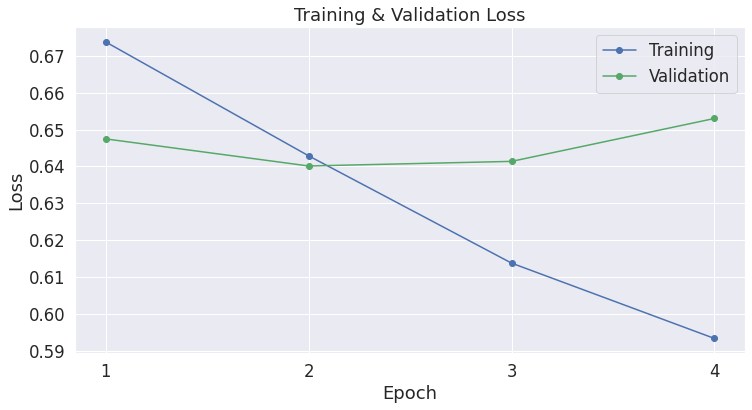

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df  = df.iloc[sentence_ids_list_valid,]

In [ ]:
#sentences = df['removed_stop_and_lem']

In [ ]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df['removed_stop_and_lem'].values
labels = df['class'].values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 75,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
# prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 3,572



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
#   b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,572 test sentences...
    DONE.


In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (df['class'].sum(), len(df['class']), (df['class'].sum() / len(df['class']) * 100.0)))

Positive samples: 1791 of 3572 (50.14%)


In [ ]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
pred_labels = []
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  pred_labels.append(pred_labels_i)
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


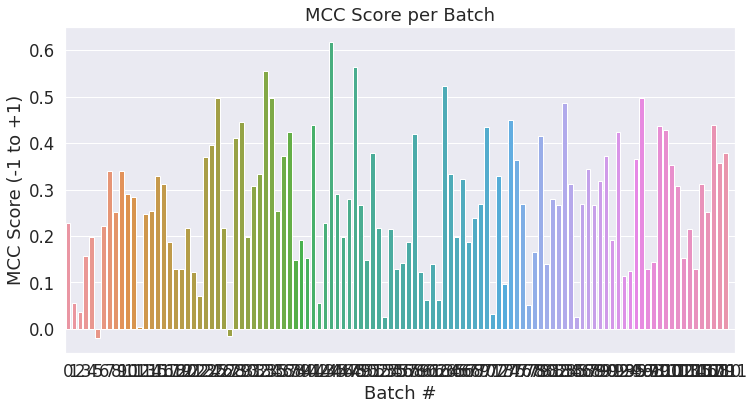

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# adding to the main datframe
df['target'] = flat_predictions

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }
get_eval_report(flat_true_labels, flat_predictions)
# print('Total MCC: %.3f' % mcc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'fn': 788, 'fp': 543, 'mcc': 0.2574716861331372, 'tn': 1238, 'tp': 1003}

In [ ]:
# Importing the metrics package from sklearn library
from sklearn import metrics
# Creating the confusion matrix
cm = metrics.confusion_matrix(flat_true_labels, flat_predictions)
# Assigning columns names
cm_df = pd.DataFrame(cm, 
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,1238,543
Actual Positive,788,1003


In [ ]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [ ]:
confusion_metrics(cm_df.to_numpy())

True Positives: 1003
True Negatives: 1238
False Positives: 543
False Negatives: 788
--------------------------------------------------
Accuracy: 0.63
Mis-Classification: 0.37
Sensitivity: 0.56
Specificity: 0.7
Precision: 0.7
f_1 Score: 0.62
